## Facial keypoints detection

Facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` returns a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [1]:
import numpy as np
import pandas as pd
import os
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

def load_imgs_and_keypoints(dirname='facial-keypoints'):
    data = pd.read_csv(os.path.join(dirname, 'gt.csv'))
    imgs = []
    points = []
    for i, file_name in enumerate(data['filename']):
        img = imread(os.path.join(dirname, 'images', file_name))
        h, w = img.shape[:2]
        imgs.append(resize(img, (100, 100, 3), mode='constant'))
        img_points = []
        for j in range(1, 15):
            x, y = 'x{}'.format(j), 'y{}'.format(j)
            img_points.append(data.loc[i, x] / w - 0.5)
            img_points.append(data.loc[i, y] / h - 0.5)
        points.append(img_points)
        
        if i % 500 == 0:
            print('img{}'.format(i), end=' ')
    
    return np.array(imgs), np.array(points)

imgs, points = load_imgs_and_keypoints()

In [2]:
imgs.shape, points.shape

((6000, 100, 100, 3), (6000, 28))

/home/aoryabinina/venv/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

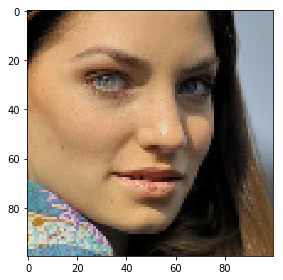

In [3]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image.

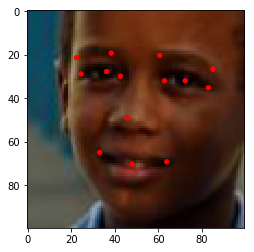

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def visualize_points(img, points):
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for i in range(0, len(points), 2):
        x = 100 * (points[i] + 0.5)
        y = 100 * (points[i + 1] + 0.5)
        ax.add_patch(Circle((x, y), radius=1, color='red'))
    plt.show()
    
visualize_points(imgs[1], points[1])

### Train/val split

In [5]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

In [6]:
imgs_train.shape, imgs_val.shape, points_train.shape, points_val.shape

((5400, 100, 100, 3), (600, 100, 100, 3), (5400, 28), (600, 28))

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Function flip_img flips an image and its' points.

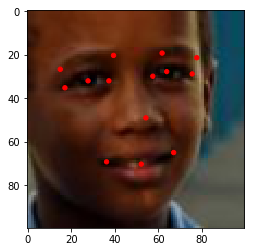

In [7]:
def flip_img(img, points):
    f_points = list(points)
    for i in range(0, len(points), 2):
        f_points[i] = -points[i]
    f_points[6:8], f_points[0:2] = f_points[0:2], f_points[6:8]
    f_points[2:4], f_points[4:6] = f_points[4:6], f_points[2:4]
    f_points[8:10], f_points[18:20] = f_points[18:20], f_points[8:10]
    f_points[10:12], f_points[16:18] = f_points[16:18], f_points[10:12]
    f_points[12:14], f_points[14:16] = f_points[14:16], f_points[12:14]
    f_points[22:24], f_points[26:28] = f_points[26:28], f_points[22:24]
    return img[:, ::-1], f_points

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. We apply flip to every image in training sample. As a result we obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [8]:
imgs_train.shape, points_train.shape

((5400, 100, 100, 3), (5400, 28))

In [9]:
aug_imgs_train = []
aug_points_train = []
for img, points in zip(imgs_train, points_train):
    f_img, f_points = flip_img(img, points)
    aug_imgs_train.extend([img, f_img])
    aug_points_train.extend([points, f_points])
aug_imgs_train, aug_points_train = np.array(aug_imgs_train), np.array(aug_points_train)
aug_imgs_train.shape, aug_points_train.shape

((10800, 100, 100, 3), (10800, 28))

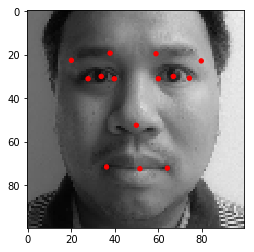

In [10]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

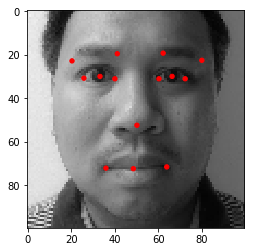

In [11]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

We normalize input images for better learning

In [12]:
def normalize(imgs):
    norm_imgs = np.array(imgs)
    for channel in range(3):
        mu = np.mean(imgs[..., channel])
        sigma = np.std(imgs[..., channel])
        for i in range(len(imgs)):
            norm_imgs[i, :, :, channel] = (norm_imgs[i, :, :, channel] - mu) / sigma
    return norm_imgs

In [13]:
aug_imgs_train_norm = normalize(aug_imgs_train)
imgs_val_norm = normalize(imgs_val)

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point.

In [15]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Activation, BatchNormalization
)
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler

model = Sequential()
model.add(Conv2D(32, 3, 3, input_shape=(100, 100, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, 2, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, 2, 2, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(28))

/home/aoryabinina/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/aoryabinina/venv/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(100, 100,..., activation="relu")`
/home/aoryabinina/venv/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (2, 2), activation="relu")`
/home/aoryabinina/venv/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2), activation="relu")`


In [17]:
adam = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam)

In [28]:
lr = np.linspace(0.01, 0.0001, 70)
change_lr = LearningRateScheduler(lambda epoch: lr[epoch])

hist = model.fit(aug_imgs_train_norm, aug_points_train, batch_size=128, epochs=70, validation_split=0.1, 
                 callbacks=[change_lr], initial_epoch=60)

Train on 9720 samples, validate on 1080 samples
Epoch 61/70
9720/9720 [==============================] - 68s 7ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 62/70
9720/9720 [==============================] - 67s 7ms/step - loss: 0.0012 - val_loss: 9.1597e-04
Epoch 63/70
9720/9720 [==============================] - 67s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 64/70
9720/9720 [==============================] - 68s 7ms/step - loss: 0.0011 - val_loss: 9.9646e-04
Epoch 65/70
9720/9720 [==============================] - 68s 7ms/step - loss: 0.0011 - val_loss: 9.2279e-04
Epoch 66/70
9720/9720 [==============================] - 68s 7ms/step - loss: 0.0010 - val_loss: 9.9245e-04
Epoch 67/70
9720/9720 [==============================] - 68s 7ms/step - loss: 0.0011 - val_loss: 9.4929e-04
Epoch 68/70
9720/9720 [==============================] - 68s 7ms/step - loss: 0.0010 - val_loss: 8.8818e-04
Epoch 69/70
9720/9720 [==============================] - 68s 7ms/step - loss: 0.0011 - val_loss:

In [267]:
score = model.evaluate(imgs_val_norm, points_val, verbose=0)
print('Test loss:', score)

Test loss: 0.0012598369860400756


### Visualize results

Now we visualize neural network results on several images from validation sample.

In [248]:
img = 6

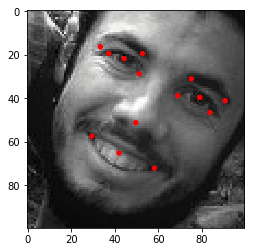

In [249]:
visualize_points(imgs_val[img], points_val[img])

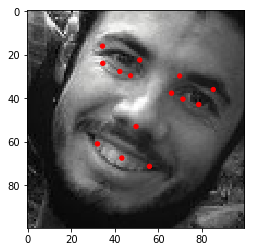

In [255]:
visualize_points(imgs_val[img], model.predict(imgs_val_norm)[img])